In [1]:
%matplotlib inline
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import random
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from copy import deepcopy
import networkx.algorithms.community.quality as nxq
import community as community_louvain

In [ ]:
# inconvénient de l'implémentation: les labels des nodes doivent commencer à 0

# Leiden Community detection algorithm

In [87]:
G = nx.karate_club_graph()
print(f'There are {len(G.nodes())} nodes and {len(G.edges())} edges')

There are 34 nodes and 78 edges


In [88]:
print(G.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


## Phase 1

In [3]:
def community_to_dict(communities):
    commu = {}
    for i, com in enumerate(communities):
        for node in com:
            commu[node] = i
    return commu

In [4]:
community = [{0, 1, 6, 8}, {2, 3, 4, 5, 7}]

In [5]:
def find_community_i(community, i):
    for ind, com in enumerate(community):
        if i in com:
            return ind

In [6]:
find_community_i(community, 8)

0

In [7]:
def delete_from_com(community, ind, i):
    com = deepcopy(community)
    com[ind].remove(i)
    return com

In [8]:
delete_from_com(community, 0, 8)

[{0, 1, 6}, {2, 3, 4, 5, 7}]

In [9]:
def add_to_community(community, ind, i):
    com = deepcopy(community)
    com[ind].add(i)
    return com

In [10]:
add_to_community(community, 0, 8)

[{0, 1, 6, 8}, {2, 3, 4, 5, 7}]

In [165]:
def phase1(graph):

    # initialize the communities: each node in a different community
    communities = []
    for node in graph.nodes():
        communities.append({node})

    best_mod = nxq.modularity(graph, communities, weight='weight')
    best_community = communities

    count = 0
    while 1:
        count += 1
        for node in graph.nodes():
            com = deepcopy(best_community)
            ind_node = find_community_i(com, node)
            neigh_node = graph.neighbors(node)
            for neigh in neigh_node:
                com_bis = deepcopy(com)
                ind_neigh = find_community_i(com_bis, neigh)
                com_bis = delete_from_com(com_bis, ind_node, node)
                com_bis = add_to_community(com_bis, ind_neigh, node)
                com_bis = [s for s in com_bis if s != set()]
                mod = nxq.modularity(graph, com_bis, weight='weight') # Attention ca doit etre le gain de modularité
                if mod > best_mod:
                    best_mod = mod
                    best_community = com_bis.copy()
        if com == best_community:
            break
    best_community = [s for s in best_community if s != set()]
    return best_community, best_mod
    

In [18]:
def size_link_between_com(com1, com2, graph):

    link = 0
    for node1 in com1:
        for node2 in com2:
            data = graph.get_edge_data(node1, node2)
            if data != None:
                if data != {}:
                    link += data['weight']
                else:
                    link += 1
    return link

In [46]:
def phase2(communities, graph):

    nodes = graph.nodes()
    edges = graph.edges()

    new_nodes = [i for i in range(len(communities))]
    new_edges = []

    new_graph = nx.Graph()
    new_graph.add_nodes_from([i for i in range(len(communities))])


    for i, com1 in enumerate(communities):
        for j, com2 in enumerate(communities):
            if i >= j:
                if i == j:
                    # self_loops
                    nodes_in_com = [node for node in com1]
                    subGraph = graph.subgraph(nodes_in_com)
                    new_edges.append((i,i, {'weight':subGraph.size(weight='weight')}))
                else:
                    link = size_link_between_com(com1, com2, graph)
                    if link > 0:
                        new_edges.append((i,j, {'weight':link}))

    new_graph.add_edges_from(new_edges)
    return new_graph

In [47]:
new_graph = phase2(best_community, G)

In [72]:
def merge_communities(communities, best_communities):

    new_communities = []

    for com in best_communities:
        uni = set()
        for element in com:
            uni = uni.union(communities[element])
        new_communities.append(uni)
    return new_communities      

In [76]:
new_communities = merge_communities(best_community, b_communities)

In [126]:
def load_graph(file_path):
    assert ('txt' in file_path), 'Please choose a graph file of type txt'

    G = nx.read_edgelist(file_path,create_using=nx.Graph(), nodetype = int)
    return G

In [166]:
def louvain_algorithm(G):

    prev_best_community, prev_best_mod = None, None
    communities = []
    for i, node in enumerate(G.nodes()):
        communities.append({i})

    while 1:

        print('phase1')
        best_communities, best_mod = phase1(G)

        print('phase2')
        G = phase2(best_communities, G)

        if best_mod == prev_best_mod:
            break
        else:
            prev_best_community, prev_best_mod = best_communities, best_mod

        communities = merge_communities(communities, best_communities)

    return communities, best_mod

In [167]:
G = load_graph('karate.txt')
communities, best_mod = louvain_algorithm(G)

phase1
phase2
phase1
phase2
phase1
phase2


In [168]:
print(communities)
print(best_mod)

[{0, 33, 9, 15, 16, 19, 21, 23, 27, 30, 31}, {1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22}, {17, 5, 6, 7, 11}, {32, 24, 25, 26, 28, 29}]
0.42983639736886486


In [105]:
import unittest
import math

class PylouvainTest(unittest.TestCase):

    def test_karate_club(self):
        partition, q = louvain_algorithm('karate.txt')
        q_ = q * 10000
        self.assertEqual(4, len(partition))
        self.assertEqual(4298, math.floor(q_))
        self.assertEqual(4299, math.ceil(q_))

In [112]:
com = community_to_dict(communities)

In [113]:
print(com)

{1: 0, 2: 0, 3: 0, 4: 0, 8: 0, 10: 0, 12: 0, 13: 0, 14: 0, 18: 0, 20: 0, 22: 0, 17: 1, 5: 1, 6: 1, 7: 1, 11: 1, 32: 2, 24: 2, 25: 2, 26: 2, 28: 2, 29: 2, 0: 3, 33: 3, 9: 3, 15: 3, 16: 3, 19: 3, 21: 3, 23: 3, 27: 3, 30: 3, 31: 3}


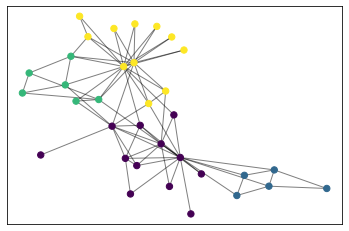

In [117]:
import matplotlib.cm as cm

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(com.values()) + 1)
nx.draw_networkx_nodes(G, pos, com.keys(), node_size=40,
                       cmap=cmap, node_color=list(com.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()